In [1]:
import os
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import pandas as pd
import math
from PIL import Image
import sys
import random
from matplotlib import pyplot as plt

In [2]:
# !pip3 install pandas

In [3]:
tf.__version__
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

'2.6.0-dev20210425'

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6500)])
  except RuntimeError as e:
    print(e)

In [6]:
from utils import movie_images_to_dict

In [7]:
trainning_folder="trainning_images"
test_folder="test"

In [8]:
number_of_trainning_videos=len(os.listdir(f'{trainning_folder}'))
number_of_test_videos=1

In [9]:
os.listdir(f'{trainning_folder}')

['nonprimate_clip_120',
 'nonprimate_clip_187',
 'nonprimate_clip_145',
 'nonprimate_clip_191',
 'nonprimate_clip_197',
 'nonprimate_clip_106',
 'nonprimate_clip_169',
 'nonprimate_clip_143',
 'nonprimate_clip_156',
 'nonprimate_clip_160',
 'nonprimate_clip_174',
 'nonprimate_clip_112',
 'nonprimate_clip_101',
 'nonprimate_clip_161',
 'nonprimate_clip_118',
 'nonprimate_clip_107',
 'nonprimate_clip_172',
 'nonprimate_clip_121',
 'nonprimate_clip_116',
 'nonprimate_clip_139',
 'nonprimate_clip_162',
 'nonprimate_clip_157',
 'nonprimate_clip_124',
 'nonprimate_clip_131',
 'nonprimate_clip_181',
 'nonprimate_clip_144',
 'nonprimate_clip_135',
 'nonprimate_clip_168',
 'nonprimate_clip_179',
 'nonprimate_clip_186',
 'nonprimate_clip_127',
 'nonprimate_clip_111',
 'nonprimate_clip_155',
 'nonprimate_clip_108',
 'nonprimate_clip_146',
 'nonprimate_clip_198',
 'nonprimate_clip_196',
 'nonprimate_clip_176',
 'nonprimate_clip_102',
 'nonprimate_clip_130',
 'nonprimate_clip_125',
 'nonprimate_cli

In [10]:

trainning_data_set=[]
test_data_set=[]
# Loop through trainning images
for index in os.listdir(f'{trainning_folder}'):
#     print(index)
    trainning_data_set.append(pd.DataFrame(movie_images_to_dict.get_images_to_dict(f'{trainning_folder}/{index}/')).to_numpy())
# Loop through test images
for index in range(number_of_test_videos):
    test_data_set.append(pd.DataFrame(movie_images_to_dict.get_images_to_dict(f'{test_folder}/{index}/')).to_numpy())

In [11]:
pd.DataFrame(trainning_data_set[1])

,0,1,2,3
0,00000001.png,trainning_images/nonprimate_clip_187/,1080,1920
1,00000002.png,trainning_images/nonprimate_clip_187/,1080,1920
2,00000003.png,trainning_images/nonprimate_clip_187/,1080,1920
3,00000004.png,trainning_images/nonprimate_clip_187/,1080,1920
4,00000005.png,trainning_images/nonprimate_clip_187/,1080,1920
...,...,...,...,...
128,00000129.png,trainning_images/nonprimate_clip_187/,1080,1920
129,00000130.png,trainning_images/nonprimate_clip_187/,1080,1920
130,00000131.png,trainning_images/nonprimate_clip_187/,1080,1920
131,00000132.png,trainning_images/nonprimate_clip_187/,1080,1920


In [12]:
# Split in to groups
def split_in_groups(dataset,number_of_images=2,step=1):
#     Generate in groups
    dataset_gen=[dataset[i : i + number_of_images] for i in range(0, len(dataset), step) if i+number_of_images<len(dataset)]
#     Return as a numpy group
    return np.array(dataset_gen)


# Trainning groups
trainning_groups=[]
for i in range(number_of_trainning_videos):
    trainning_groups.append(split_in_groups(trainning_data_set[i],6))
trainning_groups=np.concatenate(trainning_groups,axis=0)                            
                            

# Test groups
test_groups=[]
for i in range(number_of_test_videos):
    test_groups.append(split_in_groups(test_data_set[i],6))                
test_groups=np.concatenate(test_groups,axis=0)

In [13]:
input_shape=(int(1080/8),int(1920/8),3)
input_shape

(135, 240, 3)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  K.layers.experimental.preprocessing.Resizing(input_shape[0],input_shape[1], interpolation='nearest'),
  K.layers.experimental.preprocessing.Rescaling(1./255)
])
@tf.function
def resize_image(images,y):
    new_images=[]
    for image in images:
        new_images.append(resize_and_rescale(image))
    # print(new_images)
    return tuple(new_images),y
    
@tf.function
def resize_image2(images,y):
    new_images=tf.image.resize(images,(input_shape[0],input_shape[1]),method='nearest')
    new_images=new_images/255
    # print(new_images)
    return new_images,y
# Gen
# def trainning_group_gen():
#     for trainning_group in trainning_groups:
#         images=[]
#         for record in trainning_group:
#             image=Image.open(record[1]+record[0])
#             image=image.resize((input_shape[1],input_shape[0]))
#             images.append(np.array(image)/255)

#         yield tuple(images),1
#         yield tuple(images[::-1]),0
# @tf.function
def trainning_group_gen2():
    for trainning_group in trainning_groups:
        images=[]
        for record in trainning_group:
            image=Image.open(record[1]+record[0])
            images.append(np.array(image))

        yield tuple(images),1
        yield tuple(images[::-1]),0
        
# def test_group_gen():
#     for test_group in test_groups:
#         images=[]
#         for record in test_group:
#             image=Image.open(record[1]+record[0])
#             image=image.resize((input_shape[1],input_shape[0]))
#             images.append(np.array(image)/255)
#         yield tuple(images),1
#         yield tuple(images[::-1]),0
def test_group_gen2():
    for trainning_group in test_groups:
        images=[]
        for record in trainning_group:
            image=Image.open(record[1]+record[0])
            images.append(np.array(image))

        yield tuple(images),1
        yield tuple(images[::-1]),0

In [57]:
# tensor_trainning_dataset=tf.data.Dataset.from_generator(
#     trainning_group_gen,
#     output_signature=(
#     (tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32)),
#         tf.TensorSpec(shape=(), dtype=tf.int8)
#     )
# ).batch(20).prefetch(tf.data.AUTOTUNE)


# tensor_trainning_dataset2=tf.data.Dataset.from_generator(
#     trainning_group_gen2,
#     output_signature=(
#     (tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32)),
#         tf.TensorSpec(shape=(), dtype=tf.int8)
#     )
# ).map(resize_image, num_parallel_calls=tf.data.AUTOTUNE).batch(20).prefetch(tf.data.AUTOTUNE)

tensor_trainning_dataset2 = tf.data.Dataset.from_generator(
     trainning_group_gen2,
     ((tf.float32, tf.float32,tf.float32, tf.float32,tf.float32, tf.float32),tf.int8),
     (
         (tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3])
    )
    ,tf.TensorShape([])
    )).map(resize_image, num_parallel_calls=32).cache('cache').batch(20).prefetch(tf.data.AUTOTUNE)

tensor_trainning_dataset3 = tf.data.Dataset.from_generator(
     trainning_group_gen2,
     ((tf.float32, tf.float32,tf.float32, tf.float32,tf.float32, tf.float32),tf.int8),
     (
         (tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3])
    )
    ,tf.TensorShape([])
    )).map(resize_image, num_parallel_calls=32).cache('cache').batch(1).shuffle(buffer_size=5000).prefetch(tf.data.AUTOTUNE)

tensor_trainning_dataset4 = tf.data.Dataset.from_generator(
     trainning_group_gen2,
     ((tf.float32, tf.float32,tf.float32, tf.float32,tf.float32, tf.float32),tf.int8),
     (
         (tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3])
    )
    ,tf.TensorShape([])
    )).map(resize_image, num_parallel_calls=32).cache('cache').batch(1).prefetch(tf.data.AUTOTUNE)
# tensor_test_dataset=tf.data.Dataset.from_generator(
#     test_group_gen,
#     output_signature=(
#     (tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32)),
#         tf.TensorSpec(shape=(), dtype=tf.int8)
#     )
# ).batch(3).prefetch(tf.data.AUTOTUNE)

In [16]:

# tf.math.reduce_mean(np.array([[1,2,3],[2,3,4]],dtype=np.float32),axis=0)

In [17]:
# for i in tensor_trainning_dataset2:
#     pass

In [18]:

def block(block,num_filters):
    block=K.layers.Conv2D(num_filters,3,padding='same')(block)
    block=K.layers.LeakyReLU()(block)
    block=K.layers.BatchNormalization()(block)
    # block=K.layers.Dropout(.1)(block)
    block=K.layers.MaxPool2D((3,3))(block)
    return block
start=K.layers.Input(shape=input_shape)
block_1=block(start,64)
block_2=block(block_1,128)
block_3=block(block_2,256)
block_4=block(block_3,512)
global_max=K.layers.GlobalMaxPool2D()(block_4)
conv=K.Model(inputs=start,outputs=global_max)


image_1=K.Input(input_shape)
image_2=K.Input(input_shape)
image_3=K.Input(input_shape)
image_4=K.Input(input_shape)
image_5=K.Input(input_shape)
image_6=K.Input(input_shape)

image_1_nn=conv(image_1)
image_2_nn=conv(image_2)
image_3_nn=conv(image_3)
image_4_nn=conv(image_4)
image_5_nn=conv(image_5)
image_6_nn=conv(image_6)

def add(images):
    return images[0]+images[1]+images[2]+images[3]+images[4]+images[5]

lambda_layer=tf.keras.layers.Concatenate()([image_1_nn,image_2_nn,image_3_nn,image_4_nn,image_5_nn,image_6_nn])
fc_1=K.layers.Dense(200)(lambda_layer)
fc_1=K.layers.LeakyReLU()(fc_1)
fc_1=K.layers.Dense(200)(fc_1)
fc_1=K.layers.LeakyReLU()(fc_1)
fc_1=K.layers.Dense(200)(fc_1)
fc_1=K.layers.LeakyReLU()(fc_1)
fc_1=K.layers.Dense(100)(fc_1)
fc_1=K.layers.LeakyReLU()(fc_1)
fc_1=K.layers.Dense(100)(fc_1)
fc_1=K.layers.LeakyReLU()(fc_1)
# fc_1=K.layers.LeakyReLU()(fc_1)
fc_2=K.layers.Dense(2,activation='softmax')(fc_1)
# fc_2=K.layers.Dense(2)(fc_1)
# fc_2=K.layers.Activation('softmax', dtype='float32', name='predictions')(fc_2)
# bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model=K.Model(inputs=[image_1,image_2,image_3,image_4,image_5,image_6],outputs=fc_2)


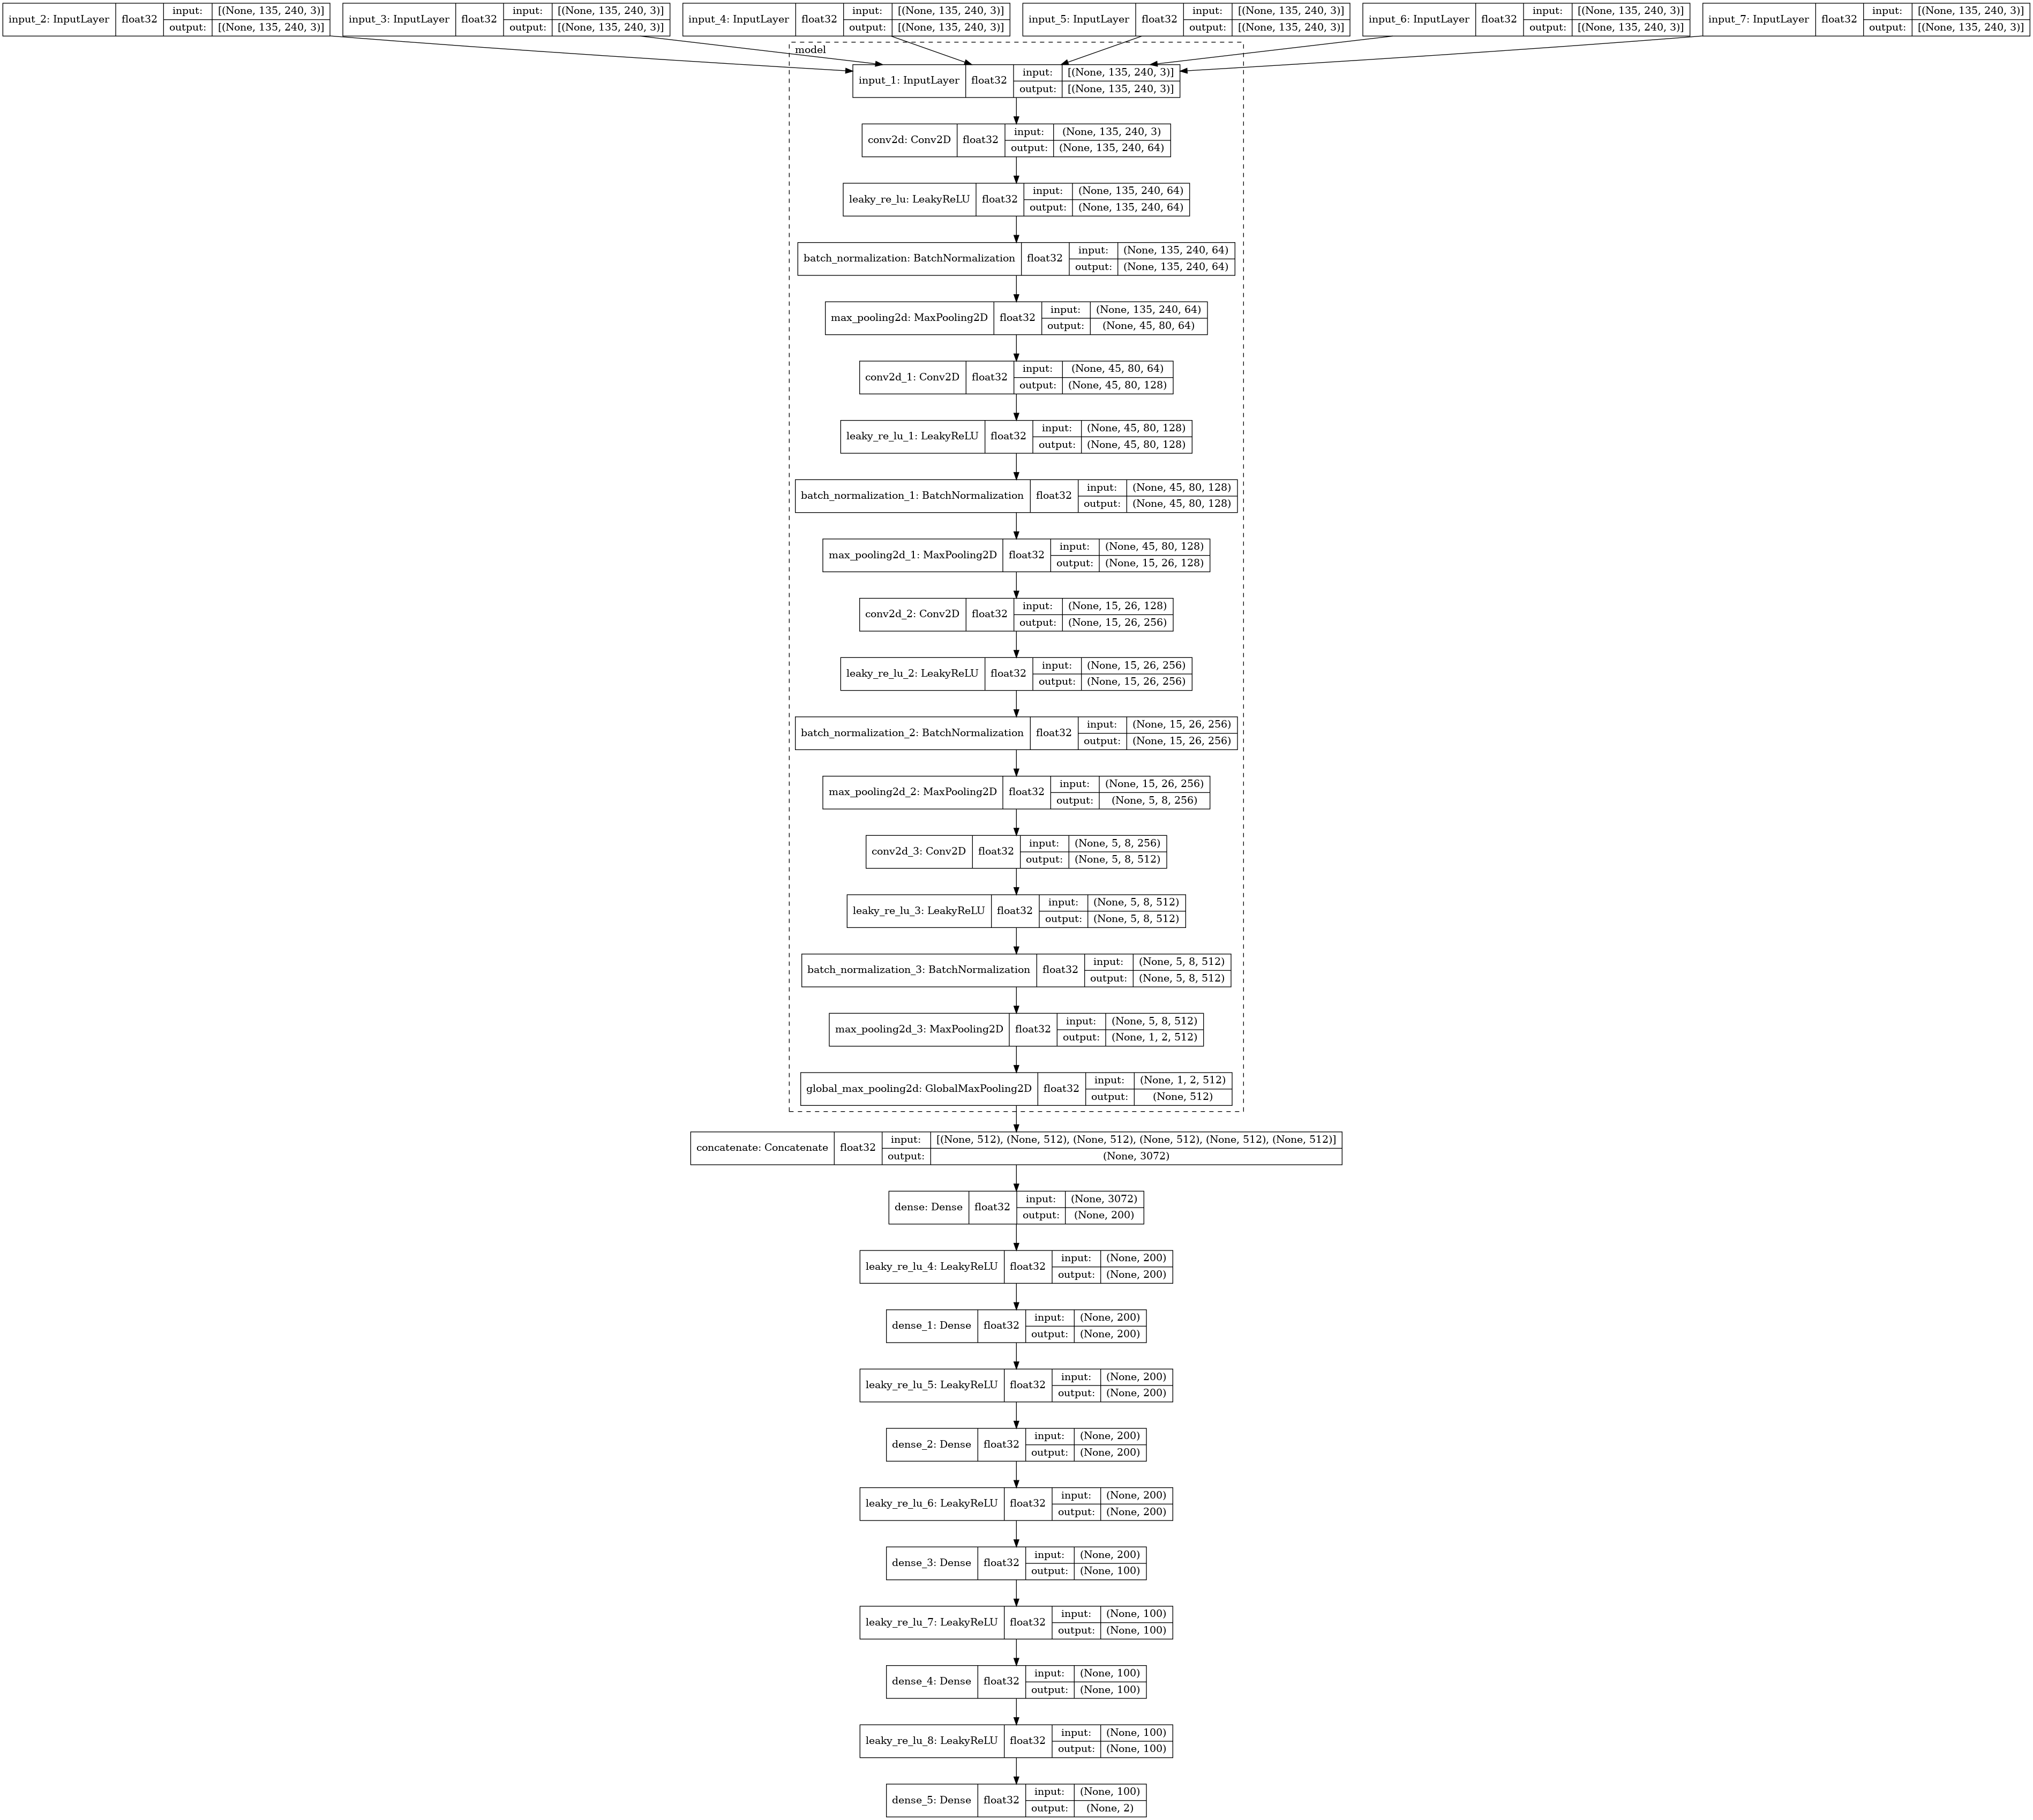

In [19]:
K.utils.plot_model(model,show_shapes=True,expand_nested=True,show_dtype=True)

In [20]:
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(
#     options = run_opts,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=K.optimizers.Adam(learning_rate=0.00005),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.SparseCategoricalCrossentropy()]
)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 135, 240, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 135, 240, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 135, 240, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 135, 240, 3) 0                                            
____________________________________________________________________________________________

In [ ]:
model = tf.keras.models.load_model('back4ards')
model.compile(
#     options = run_opts,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=K.optimizers.Adam(learning_rate=0.00005),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.SparseCategoricalCrossentropy()]
)
history=model.fit(tensor_trainning_dataset2,epochs=500)

Epoch 1/500
    682/Unknown - 75s 108ms/step - loss: 0.1251 - binary_accuracy: 0.5000 - mean_squared_error: 0.4600 - sparse_categorical_crossentropy: 0.1251

<Figure size 432x288 with 0 Axes>

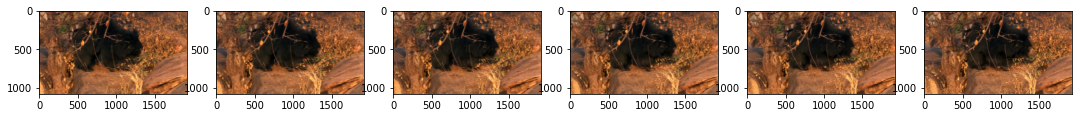

True direction: backwards
[[0.45455286 0.5454471 ]] Model prediction: forwards  with a 54.544711112976074% prediction


<Figure size 432x288 with 0 Axes>

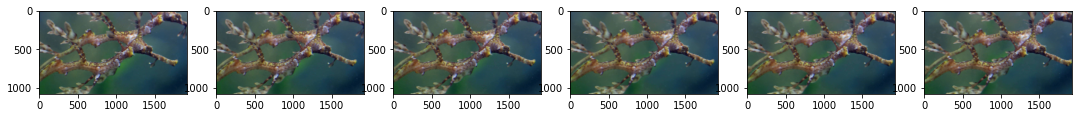

True direction: forwards
[[0.01283529 0.98716474]] Model prediction: forwards  with a 98.71647357940674% prediction


In [55]:
for i in tensor_trainning_dataset3.take(2):
    output=model.predict(i[0])
    plt.figure()
    f, axarr = plt.subplots(1,6)
    for index,image in enumerate(i[0]):
        axarr[index].imshow(tf.image.resize(i[0][index][0],(1080,1920),'nearest'))
#         axarr[index].imshow(i[0][index][0])
    f.set_size_inches(18.5, 10.5)
    plt.show()
    print("True direction:","forwards" if i[1][0]  else "backwards")
    print(output,"Model prediction:", "forwards" if np.argmax(output) else "backwards",f" with a {output[0][np.argmax(output)]*100}% prediction")
#         plt.imshow()
#     output[np.argmax(output,axis=1)]
#     forwards=np.argmax(output,axis=1)[::2]
#     backwards=np.argmax(output,axis=1)[1::2]

#     (len(forwards)-np.count_nonzero(forwards))
    
#     print(forwards==0) # Video going backwards output should be 0
#     print(backwards==1) # Video going forwards output should be 1
#     totalForwards+=np.count_nonzero(forwards==0)
#     totalBackwards+=np.count_nonzero(forwards==1)
#     forwardsDetections+=len(forwards)
#     backwardsDetections+=len(backwards)
#     print("forwards ",totalForwards/forwardsDetections)
#     print("backwards ",totalBackwards/backwardsDetections)
#     print("acc", (((totalForwards/forwardsDetections)+(totalBackwards/backwardsDetections))/2))

In [68]:
correct=0
n=0
for i in tensor_trainning_dataset2:
    output=model.predict(i[0])
    n+=len(i[1])
    correct+=np.count_nonzero(np.argmax(output,axis=1)==i[1])
#     output=model.predict(i[0])
#     n+=1
#     if i[1][0] == np.argmax(output):
#         correct+=1
    print(correct/n)
    

0.7
0.525
0.5
0.4375
0.42
0.43333333333333335
0.44285714285714284
0.45
0.45555555555555555
0.445
0.45454545454545453
0.4583333333333333
0.46153846153846156
0.4642857142857143
0.4666666666666667
0.46875
0.47058823529411764
0.4722222222222222
0.47368421052631576
0.475
0.47619047619047616
0.4772727272727273
0.4782608695652174
0.4791666666666667
0.48
0.4807692307692308
0.4759259259259259
0.48214285714285715
0.4879310344827586
0.4866666666666667
0.4870967741935484
0.4875
0.48787878787878786
0.4970588235294118
0.49714285714285716
0.49722222222222223
0.49594594594594593
0.4934210526315789
0.49615384615384617
0.49625
0.49634146341463414
0.49642857142857144
0.4965116279069767
0.4965909090909091
0.4955555555555556
0.4956521739130435
0.4957446808510638
0.49583333333333335
0.49795918367346936
0.498
0.4980392156862745
0.4980769230769231
0.4981132075471698
0.4981481481481482
0.49818181818181817
0.4982142857142857
0.4982456140350877
0.4982758620689655
0.49830508474576274
0.5016666666666667
0.50245901

0.5597777777777778
0.5604212860310421
0.5613938053097345
0.5619205298013245
0.5627753303964758
0.5637362637362637
0.5643640350877193
0.5645514223194749
0.5641921397379913
0.5650326797385621
0.5648913043478261
0.5644251626898048
0.5643939393939394
0.5638228941684665
0.5635775862068966
0.5645161290322581
0.565343347639485
0.5662740899357601
0.5667735042735043
0.5676972281449894
0.568404255319149
0.5681528662420382
0.5690677966101695
0.5689217758985201
0.5693037974683545
0.5695789473684211
0.5695378151260504
0.5690775681341719
0.5699790794979079
0.5706680584551148
0.5713541666666667
0.5715176715176715
0.5703319502074689
0.5699792960662526
0.5690082644628099
0.5691752577319588
0.5700617283950618
0.5700205338809035
0.5689549180327869
0.5692229038854806
0.5690816326530612
0.5688391038696538
0.5690040650406504
0.5691683569979716
0.5690283400809717
0.5691919191919191
0.5700604838709677
0.570020120724346
0.5701807228915663
0.570440881763527
0.57
0.5704590818363273
0.5711155378486056
0.571868787

0.591919191919192
0.5918161434977578
0.5917133258678612
0.5916107382550335
0.5915083798882682
0.59140625
0.591304347826087
0.5914810690423162
0.5916017797552836
0.5915
0.5913984461709212
0.5914079822616408
0.5913067552602437
0.5915376106194691
0.5919889502762431
0.5918322295805739
0.5922822491730981
0.5927312775330397
0.5927392739273928
0.5926373626373627
0.5925356750823271
0.5925986842105263
0.5927163198247536
0.5931619256017505
0.5936065573770491
0.5938318777292576
0.5942748091603054
0.5940631808278867
0.5945048966267682
0.5948913043478261
0.5947339847991314
0.5950108459869848
0.5949079089924161
0.5947510822510822
0.5948648648648649
0.594438444924406
0.5944444444444444
0.5940732758620689
0.5941334768568353
0.594516129032258
0.5945757250268529
0.5944742489270386
0.5942122186495177
0.5940042826552463
0.5941711229946524
0.5944978632478632
0.5947705442902882
0.5950959488272921
0.5952609158679446
0.5953191489361702
0.5956429330499469
0.595276008492569
0.5948038176033934
0.5948093220338984

In [69]:
n

23134

In [70]:
correct

13663

In [56]:
model.save("back4ards")

INFO:tensorflow:Assets written to: back4ards/assets
